# 模型训练

In [38]:
import numpy as np
import pandas as pd
import os
import tqdm
import platform

encodingType = 'ANSI' if platform.system() == 'Windows' else'gb18030'

base_path = 'stock'

market_map = {'主板':0, '中小板':1}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16,
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24,
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6,
                '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13,
                'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20,
                '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
                '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
                '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44,
                '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52,
                '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60,
                '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68,
                '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77,
                '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85,
                '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
                '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102,
                '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

# 数据读取

In [39]:
# 首先是上市公司数据读取，这里在对是否是ST公司判断中有点小bug，
# 目前是ST的公司不代表之前是ST，目前不是ST的也不代表之前是ST。
def JudgeST(x):
    return 1 if 'ST' in x else 0

col = ['open', 'high', 'low', 'pre_close']

# 获取macd平均值
def GetMA(df, col_name, rolling_day):
    df[f'{col_name}_{str(rolling_day)}'] = df[col_name].rolling(rolling_day).mean()
    return df

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'), encoding=encodingType)
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(columns=['index', 'symbol', 'fullname'], axis='columns', inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)

# 读取指数信息
stock_index_info = pd.DataFrame()
index_ts_code_arr = ['000001.SH', '000016.SH', '000002.SH', '399001.SZ', '399007.SZ', '399008.SZ', '399101.SZ', '399102.SZ']
for ts_code in index_ts_code_arr:
    try:
        tmp_df = pd.read_csv(os.path.join(base_path, 'OldData', ts_code + '_NormalData.csv'))
    except Exception:
        print('Error when try to read csv: 'f'{ts_code}_NormalData.csv')
        continue
    else:
        # 特征工程
        # tmp_df = FeatureEngineering(tmp_df)
        stock_index_info = pd.concat((stock_index_info, tmp_df))
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
# tqdm是 Python进度条库,可以在 Python长循环中添加一个进度提示信息
for ts_code in tqdm.tqdm(company_info['ts_code']):
    # if (ts_code == '000001.SZ'):
    #     print('000001.SZ 数据不完整，跳过')
    #     continue
    try:
        tmp_df = pd.read_csv(os.path.join(base_path, 'OldData', f'{ts_code}_NormalData.csv'))
    except Exception:
        # print('Error when try to read csv: 'f'{ts_code}_NormalData.csv')
        continue
    else:
        # 还需要去除一些停牌时间很久的企业，后期加
        if len(tmp_df) < 120:  # 去除一些上市不久的企业
            print('刚上市不久企业: 'f'{ts_code}_NormalData.csv')
            remove_stock.append(ts_code)
            continue
        tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index()
        #         提取均线信息
        #     for tmp_col in col:
        #         for rolling_day in [5, 10, 13, 21, 30]:
        #             tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
        # 特征工程
        #         tmp_df = FeatureEngineering(tmp_df)
        tmp_list.append(tmp_df)
stock_info = pd.concat(tmp_list)
ts_code_map = dict(zip(stock_info['ts_code'].unique(), range(stock_info['ts_code'].nunique())))
stock_info = stock_info.reset_index()
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)
stock_info.drop('index', axis=1, inplace=True)
stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
ts_code_id = stock_info['ts_code_id']
trade_date_id = stock_info['trade_date_id']
# 把股票代码 + 日期 转换 ts_date_id
stock_info['ts_date_id'] = (10000 + ts_code_id) * 10000 + trade_date_id
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

  8%|▊         | 24/301 [00:00<00:03, 76.63it/s]

100%|██████████| 301/301 [00:00<00:00, 343.74it/s]


In [40]:
ts_code_unique_print = stock_info['ts_code'].unique()
print('读取的股票列表 length: ', ts_code_unique_print.size, '\n', ts_code_unique_print, '\n')

trade_date_print = np.sort(stock_info['trade_date'].unique())
print('读取的日期列表 length: ', trade_date_print.size, '\n', trade_date_print,'\n')

ts_date_id_print = np.sort(stock_info['ts_date_id'].unique())
print('映射转换列表 length: ', ts_date_id_print.size, '\n', ts_date_id_print,'\n')

tmp = stock_info[['ts_code', 'trade_date', 'ts_date_id']]
# tmp.to_csv('output.csv', index=False)

读取的股票列表 length:  59 
 ['000001.SZ' '000002.SZ' '000004.SZ' '000005.SZ' '000006.SZ' '000007.SZ'
 '000008.SZ' '000009.SZ' '000010.SZ' '000011.SZ' '000012.SZ' '000014.SZ'
 '000016.SZ' '000017.SZ' '000019.SZ' '000020.SZ' '000021.SZ' '000023.SZ'
 '000025.SZ' '000026.SZ' '000027.SZ' '000028.SZ' '000029.SZ' '000030.SZ'
 '000031.SZ' '000032.SZ' '000034.SZ' '000035.SZ' '000036.SZ' '000037.SZ'
 '000038.SZ' '000039.SZ' '000040.SZ' '000042.SZ' '000045.SZ' '000046.SZ'
 '000048.SZ' '000049.SZ' '000050.SZ' '000055.SZ' '000056.SZ' '000058.SZ'
 '000059.SZ' '000060.SZ' '000061.SZ' '000062.SZ' '000063.SZ' '000065.SZ'
 '000066.SZ' '000068.SZ' '000069.SZ' '000070.SZ' '000078.SZ' '000088.SZ'
 '000089.SZ' '000090.SZ' '000096.SZ' '000099.SZ' '000100.SZ'] 

读取的日期列表 length:  1942 
 [20120104 20120105 20120106 ... 20191224 20191225 20191226] 

映射转换列表 length:  104572 
 [100000000 100000001 100000002 ... 100581939 100581940 100581941] 



# 特征工程

In [41]:
# 特征工程
# 接下来是一些简单的特征工程，目前还没来得及做特征工程，后期做好会再更新。
# 首先是把收盘价、开盘价、最低价、最高价变换一个尺度（相当于盈亏比），若不转换直接放进去模型是很难学会的。
# 转换成盈亏比的话（相当于所有股票转化成同一个尺度了），模型更容易学会。
stock_info = stock_info_copy.copy()
col = ['close', 'open', 'high', 'low']
feature_col = []
for tmp_col in col:
    # 差值比上一个交易日的比例
    stock_info[tmp_col + '_transform'] = (stock_info[tmp_col] - stock_info['pre_close']) / stock_info['pre_close']
    feature_col.append(f'{tmp_col}_transform')

In [42]:
# 提取前5天收盘价与今天收盘价的盈亏比。
for i in range(5):
    tmp_df = stock_info[['ts_date_id', 'close']]
    tmp_df = tmp_df.rename(columns={'close': f'close_shift_{i + 1}'})
    feature_col.append(f'close_shift_{i + 1}')
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1

    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
stock_info.drop('level_0', axis=1, inplace=True)
stock_info.dropna(inplace=True)

for i in range(5):
    stock_info['close_shift_{}'.format(i+1)] = (stock_info['close'] - stock_info['close_shift_{}'.format(i+1)]) / stock_info['close_shift_{}'.format(i+1)]

print('stock_info.size: %d' % stock_info.size)

stock_info.size: 4517687


# 标签制作

In [43]:
# 在标签制作时，如果一支股票在未来5天里最高增长大于5%，最大损失大于-3%，我们将其标签标记为1，其他标签标记为0。
# 在制作标签时为了防止股价拉到5%瞬间掉下来，我们加了一点容错（6%）。
# 这里做标签其实有点bug，这里没有考虑股票先涨到5%，再跌到-3%。因为我们的止盈点是5%，
# 如果先涨到5%我们卖了就不需要考虑后面的情况了。（这个后面再改）

# make_label
# stock_info = stock_info_copy.copy()
use_col = []
for i in range(5):
    tmp_df = stock_info[['ts_date_id', 'high', 'low']]
    tmp_df = tmp_df.rename(columns={'high': f'high_shift_{i + 1}', 'low': f'low_shift_{i + 1}'})

    use_col.extend((f'high_shift_{i + 1}', f'low_shift_{i + 1}'))
    # 这里减的原因是需要作为验证数据集，需要使用未来数据来用于判断购买的准确
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] - i - 1
    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')

stock_info.dropna(inplace=True)

for i in range(5):
    stock_info[f'high_shift_{i + 1}'] = (stock_info[f'high_shift_{i + 1}'] - stock_info['close']) / stock_info['close']
    stock_info[f'low_shift_{i + 1}'] = (stock_info[f'low_shift_{i + 1}'] - stock_info['close']) / stock_info['close']

tmp_array = stock_info[use_col].values
max_increase = np.max(tmp_array, axis=1)
min_increase = np.min(tmp_array, axis=1)
stock_info['label_max'] = max_increase
stock_info['label_min'] = min_increase
stock_info['label_final'] = (stock_info['label_max'] > 0.06) & (stock_info['label_min'] > -0.03)
stock_info['label_final'] = stock_info['label_final'].apply(lambda x: int(x))

stock_info = stock_info.reset_index()
stock_info.drop('index', axis=1, inplace=True)
print('stock_info.size: %d' % stock_info.size)

stock_info.size: 5667060


# 模型训练

In [44]:
# 模型数据输入准备：这里我们选取了18年1月1日至19年4月5日的数据作为训练集，
# 19年4月6号至19年4月10号的数据作为验证集，
# 19年4月17日至19年12月18日的数据作为回测数据
# （这是一段黑暗的行情，看看我们的模型在黑暗的行情下有什么表现）。

trn_col = ['open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'ts_code_id'] + feature_col
# 选取了18年1月1日至19年4月5日的数据作为训练集
trn_date_min = 20180101
trn_date_max = 20190405
# 19年4月6号至19年4月10号的数据作为验证集
val_date_min = 20190406
val_date_max = 20190410
# 19年4月17日至19年12月18日的数据作为回测数据
test_date_min = 20190708
test_date_max = 20191218
# test_date_min = 20190408
# test_date_max = 20190705

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max)
val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

stock_info.to_csv('output.csv', index=False)

label = 'label_final'
trn = stock_info[trn_data_idx][trn_col].values
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col].values
val_label = stock_info[val_data_idx][label].values

test = stock_info[test_data_idx][trn_col].values
test_label = stock_info[test_data_idx][label].values

In [45]:
print('rate of trn_label == 0(负样本占比): %.4f, rate of trn_label == 1(正样本占比): %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn训练数据集长度 :%d, val验证数据集长度:%d, test测试数据集长度:%d' % (len(trn), len(val), len(test)))
print('number of features: %d' % len(trn_col))

rate of trn_label == 0(负样本占比): 0.7920, rate of trn_label == 1(正样本占比): 0.2080
trn训练数据集长度 :16535, val验证数据集长度:171, test测试数据集长度:6429
number of features: 19


In [46]:
# 可以发现样本中正负样本比为1：4，使用了19个特征。
# 模型训练时我们使用了LGB，还没有尝试其他模型，但是应该LGB就够了。

# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics

param = {
    'num_leaves': 50,
    # 'n_estimatores': 3000,
    'min_data_in_leaf': 20,
    'objective': 'binary',
    # 'max_depth': 5,
    'learning_rate': 0.01,
    # "min_child_samples": 20,
    "boosting": "gbdt",
    # "feature_fraction": 0.45,
    "bagging_freq": 2,
    # "bagging_fraction": 0.8,
    "bagging_seed": 20,
    "verbosity": -1
}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round = 2000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets=[trn_data, val_data],
                verbose_eval=300,
                early_stopping_rounds=1500)
oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)
# 机器学习模型训练过程中的两个评估指标：binary_logloss。这些指标通常用于评估二元分类问题中的模型性能。
# training's binary_logloss: 0.440454：这表示在训练数据集上的二元对数损失（binary log loss）是0.440454。对数损失（log loss）是一种衡量预测概率与实际标签之间差异的指标。对于二元分类，它衡量了模型预测正类概率与实际正类标签之间的不一致程度。数值越低，表示模型在训练数据上的表现越好。
# valid_1's binary_logloss: 0.364005：这表示在验证数据集（标记为valid_1）上的二元对数损失是0.364005。验证数据集通常用于在训练过程中评估模型的性能，以监控过拟合和选择最佳模型。
# 从这两个数字可以看出，模型在验证数据集上的性能（以binary_logloss衡量）比在训练数据集上要好。这是一个好迹象，表明模型可能没有过拟合，或者至少没有过拟合得很严重。然而，为了确定模型是否真正泛化良好，还需要在独立的测试数据集上进行评

Training until validation scores don't improve for 1500 rounds


d:\Program Files\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\Program Files\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	training's binary_logloss: 0.428884	valid_1's binary_logloss: 0.363936
[600]	training's binary_logloss: 0.383867	valid_1's binary_logloss: 0.360553
[900]	training's binary_logloss: 0.347517	valid_1's binary_logloss: 0.362297
[1200]	training's binary_logloss: 0.316318	valid_1's binary_logloss: 0.360526
[1500]	training's binary_logloss: 0.288382	valid_1's binary_logloss: 0.36157
[1800]	training's binary_logloss: 0.262944	valid_1's binary_logloss: 0.361648
Did not meet early stopping. Best iteration is:
[2000]	training's binary_logloss: 0.248463	valid_1's binary_logloss: 0.361795


# 模型评价

In [47]:
oof_lgb_final = np.round(oof_lgb)
print(metrics.accuracy_score(val_label, oof_lgb_final))
print(metrics.confusion_matrix(val_label, oof_lgb_final))
tp = np.sum(((oof_lgb_final == 1) & (val_label == 1)))
pp = np.sum(oof_lgb_final == 1)
# 模型敏感度为0.5，意思就是选了10个股票，5支股票在未来5天涨幅能达到5%。
print('sensitivity 灵敏度:%.3f'% (tp/(pp)))

0.8888888888888888
[[152   1]
 [ 18   0]]
sensitivity 灵敏度:0.000


In [48]:
thresh_hold = 0.6
oof_test_final = test_lgb >= thresh_hold
print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('sensitivity灵敏度:%.3f'% (tp/(pp)))

0.8242339399595583
[[5277   54]
 [1076   22]]
sensitivity灵敏度:0.289


In [49]:
test_positive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
test_all_idx = np.argwhere(np.array(test_data_idx)).reshape(-1)

In [50]:
print('读取的正样本列表 length: ', test_positive_idx.size, '\n', test_positive_idx, '\n')
print('读取的测试列表 length: ', test_all_idx.size, '\n', test_all_idx, '\n')

读取的正样本列表 length:  76 
 [ 178  325  350  352  365  369  399  691  703  705  706  707  727  728
  751  754  755  762  763  902  916  917  919  939  953  955  956  958
  987  988  995 1006 1141 1142 1326 1364 1443 1475 1476 1482 1684 1710
 1712 1733 1751 2718 3881 3891 3913 4234 4341 4348 4349 4458 4459 4460
 4796 5015 5019 5254 5290 5330 5354 5355 5356 5429 5578 5690 5694 5707
 5724 6201 6210 6235 6236 6348] 

读取的测试列表 length:  6429 
 [ 1673  1674  1675 ... 94447 94448 94449] 



In [51]:
# 查看选了哪些股票
tmp_col = ['ts_code', 'name', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'amount', 'is_ST', 'label_max', 'label_min', 'label_final']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_positive_idx]].reset_index()
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)
buy_df.to_csv('output_account_info.csv', index=False)

In [52]:
print(len(buy_df), sum(buy_df['label_final']))
print(buy_df)
buy_df.to_csv('output_buyer_info.csv', index=False)

48 11
      ts_code   name  trade_date     open     high     low    close  \
0   000002.SZ    万科A    20191016  26.9700  27.7300  26.910  27.0700   
1   000005.SZ   世纪星源    20190708   3.3400   3.3500   3.100   3.1200   
2   000005.SZ   世纪星源    20190814   2.7900   2.8100   2.750   2.7600   
3   000005.SZ   世纪星源    20190902   3.0500   3.1700   3.050   3.1600   
4   000005.SZ   世纪星源    20190906   3.5800   3.7300   3.540   3.5600   
5   000008.SZ   神州高铁    20190904   3.5800   3.6600   3.570   3.6400   
6   000008.SZ   神州高铁    20190906   3.6400   3.6700   3.600   3.6400   
7   000008.SZ   神州高铁    20190909   3.6600   3.6800   3.610   3.6600   
8   000008.SZ   神州高铁    20191016   3.6000   3.6200   3.540   3.5600   
9   000008.SZ   神州高铁    20191119   3.3600   3.4900   3.350   3.4300   
10  000008.SZ   神州高铁    20191122   3.4100   3.4600   3.400   3.4200   
11  000008.SZ   神州高铁    20191125   3.4400   3.5300   3.440   3.5000   
12  000008.SZ   神州高铁    20191204   3.5300   3.5900   3.510   3.5700   


# 回测

In [56]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

In [57]:
tmp_idx = (index_df['trade_date'] == test_date_min)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [58]:
from imp import reload
import Account
reload(Account)
money_init = 1000000
account = Account.Account(money_init)
account.BackTest(buy_df, stock_info_copy, index_df)

account.info

20190708  买入 世纪星源 (000005.SZ) 64100股，股价：3.12,花费：199992.0,手续费：60.0，剩余现金：799948.0
结算日: 20190708 总市值: 999940.0024
20190709  止损卖出世纪星源 (000005.SZ) 64100股，股价：2.9952,收入：191992.32,手续费：249.59，剩余现金：991690.73，最终亏损：-8309.27
结算日: 20190709 总市值: 991690.732384
结算日: 20190710 总市值: 991690.732384
结算日: 20190711 总市值: 991690.732384
结算日: 20190712 总市值: 991690.732384
20190715  买入 中信海直 (000099.SZ) 26600股，股价：7.45,花费：198170.0,手续费：59.45，剩余现金：793461.28
结算日: 20190715 总市值: 991631.281384
结算日: 20190716 总市值: 991631.281384
结算日: 20190717 总市值: 988971.281384
20190718  止损卖出中信海直 (000099.SZ) 26600股，股价：7.152,收入：190243.2,手续费：247.32，剩余现金：983457.17，最终亏损：-8233.57
结算日: 20190718 总市值: 983457.165224
20190719  买入 康达尔 (000048.SZ) 10400股，股价：18.7446,花费：194943.84,手续费：58.48，剩余现金：788454.84
结算日: 20190719 总市值: 983398.682072
结算日: 20190722 总市值: 980168.442072
结算日: 20190723 总市值: 980975.482072
结算日: 20190724 总市值: 981076.362072
20190725  到期卖出康达尔 (000048.SZ) 10400股，股价：18.4437,收入：191814.48,手续费：249.36，剩余现金：980019.96，最终亏损：-3437.2
结算日: 20190725 总市值: 980019.

结算日: 20190801 总市值: 975382.483248
20190802  止损卖出*ST美丽 (000010.SZ) 53600股，股价：3.504,收入：187814.4,手续费：244.16，剩余现金：775872.72，最终亏损：-8128.45
20190802  止损卖出深华发A (000020.SZ) 18400股，股价：10.224,收入：188121.6,手续费：244.56，剩余现金：963749.77，最终亏损：-8141.75
结算日: 20190802 总市值: 963749.766448
结算日: 20190805 总市值: 963749.766448
结算日: 20190806 总市值: 963749.766448
结算日: 20190807 总市值: 963749.766448
结算日: 20190808 总市值: 963749.766448
结算日: 20190809 总市值: 963749.766448
20190812  买入 皇庭国际 (000056.SZ) 53900股，股价：3.57,花费：192423.0,手续费：57.73，剩余现金：771269.04
结算日: 20190812 总市值: 963692.039548
结算日: 20190813 总市值: 962075.039548
20190814  买入 世纪星源 (000005.SZ) 69700股，股价：2.76,花费：192372.0,手续费：57.71，剩余现金：578839.33
20190814  买入 中兴通讯 (000063.SZ) 6700股，股价：28.67,花费：192089.0,手续费：57.63，剩余现金：386692.7
结算日: 20190814 总市值: 961420.701248
20190815  止损卖出中兴通讯 (000063.SZ) 6700股，股价：27.23,收入：182441.0,手续费：237.17，剩余现金：568896.53，最终亏损：-9942.8
20190815  止损卖出皇庭国际 (000056.SZ) 53900股，股价：3.42,收入：184338.0,手续费：239.64，剩余现金：752994.89，最终亏损：-8382.37
结算日: 20190815 总市值: 944669.8885

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit
0,000005.SZ,世纪星源,3.12,20190708,64100.0,2.9952,20190709,-8309.267616
1,000099.SZ,中信海直,7.45,20190715,26600.0,7.152,20190718,-8233.56716
2,000048.SZ,康达尔,18.7446,20190719,10400.0,18.4437,20190725,-3437.201976
3,000020.SZ,深华发A,10.65,20190729,18400.0,10.224,20190802,-8141.74608
4,000010.SZ,*ST美丽,3.65,20190731,53600.0,3.504,20190802,-8128.45072
5,000056.SZ,皇庭国际,3.57,20190812,53900.0,3.42,20190815,-8382.3663
6,000005.SZ,世纪星源,2.76,20190814,69700.0,2.98,20190819,15006.2706
7,000063.SZ,中兴通讯,28.67,20190814,6700.0,27.23,20190815,-9942.8
8,000078.SZ,海王生物,3.36,20190819,56300.0,3.528,20190820,9143.43528
9,000099.SZ,中信海直,7.05,20190819,26800.0,7.44,20190821,10136.1084


In [59]:
account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:-0.0216
上证指数浮动情况:0.0285
交易胜率:0.4571
最大回撤率:0.0553


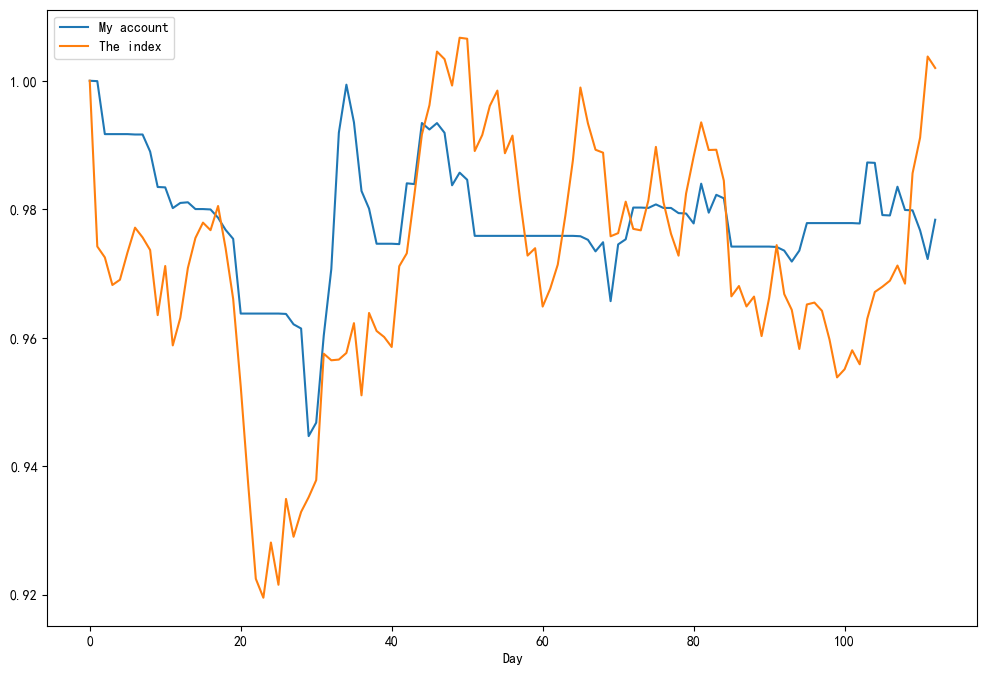

In [63]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)

e:\Project\stock_market\Draw.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(8, 3))


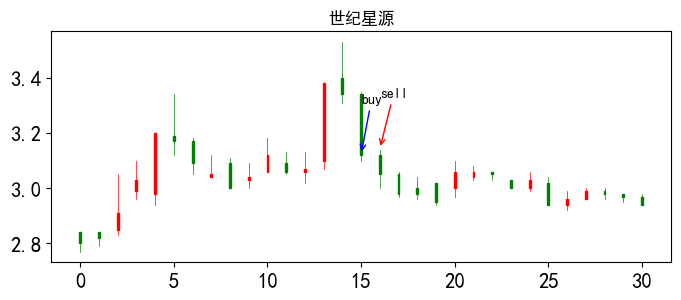

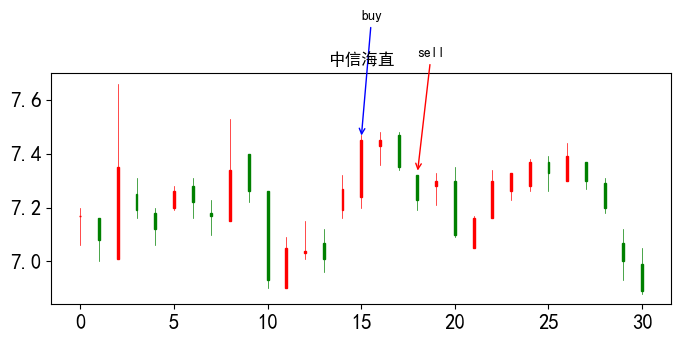

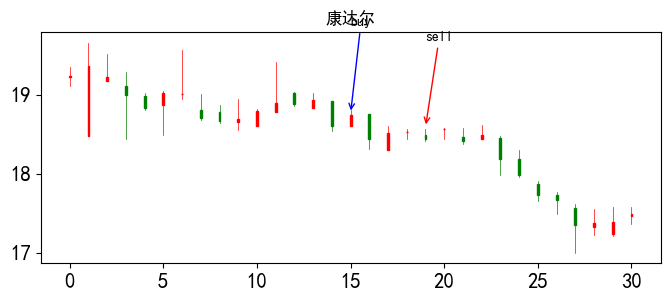

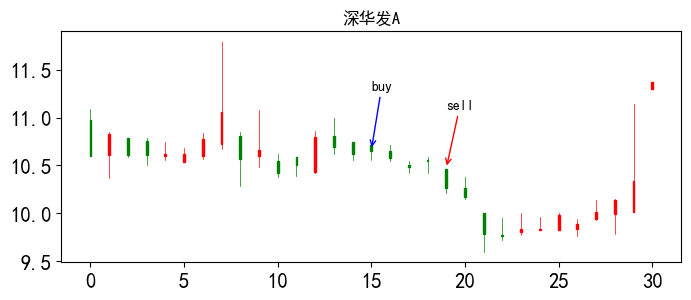

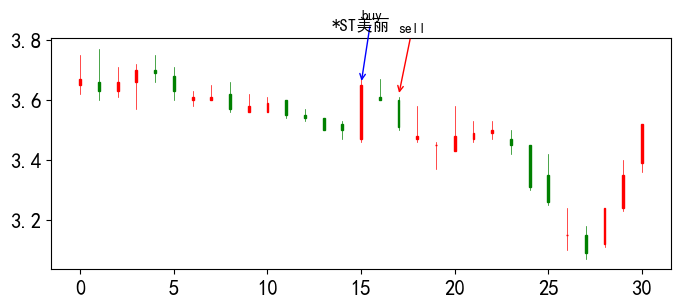

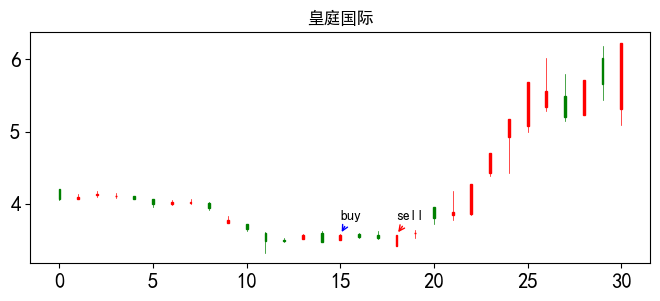

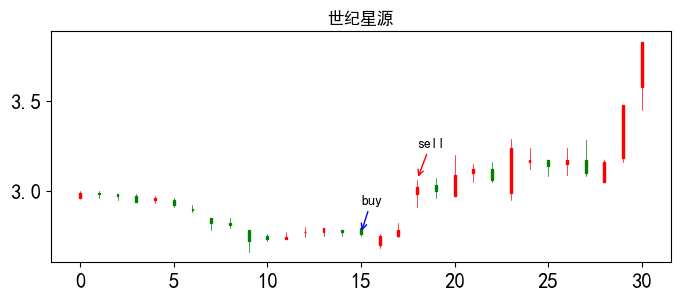

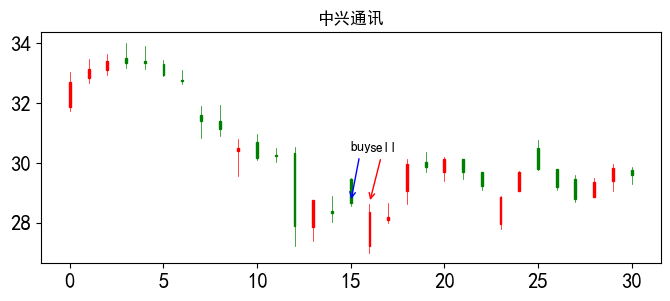

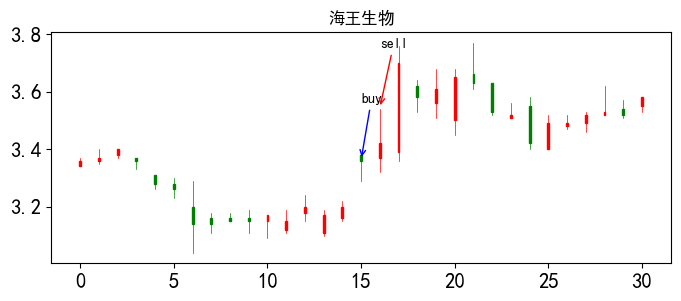

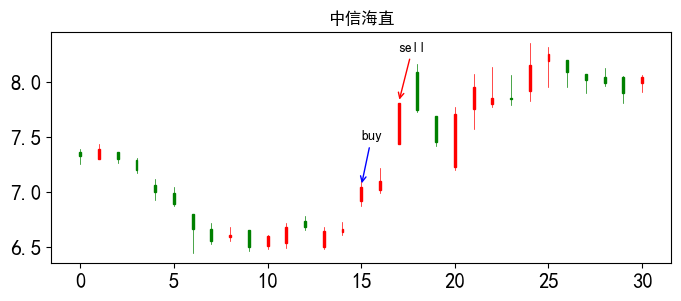

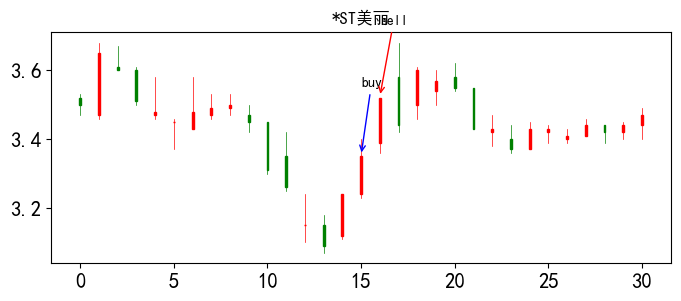

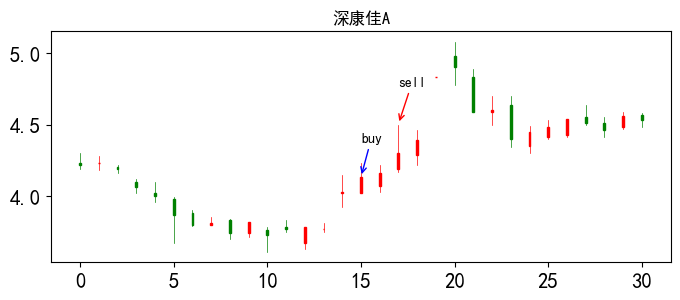

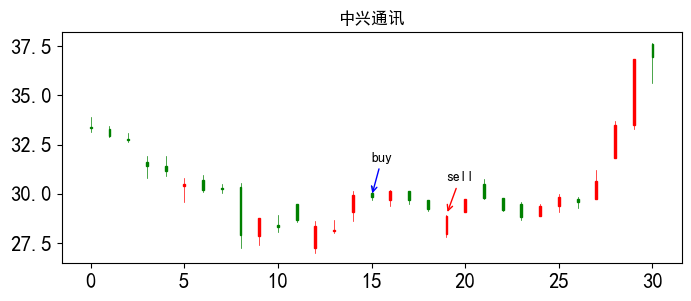

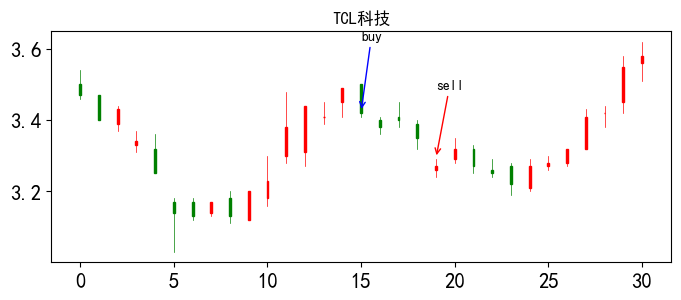

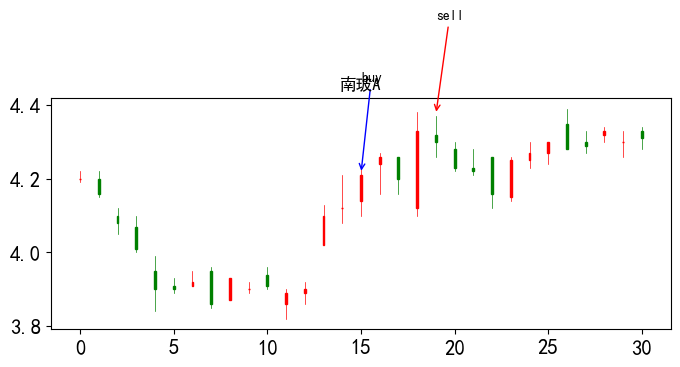

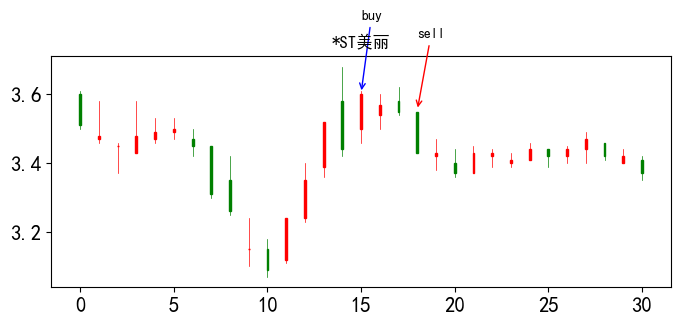

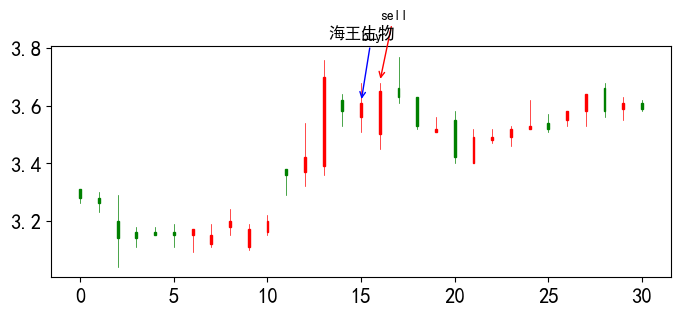

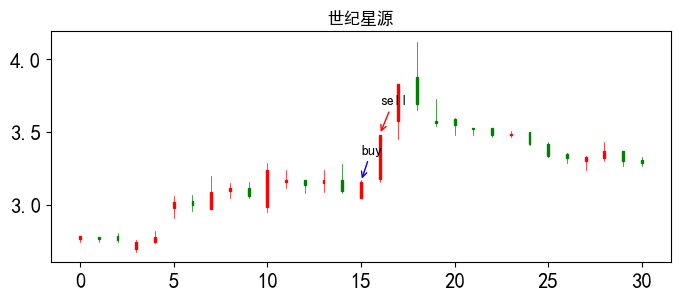

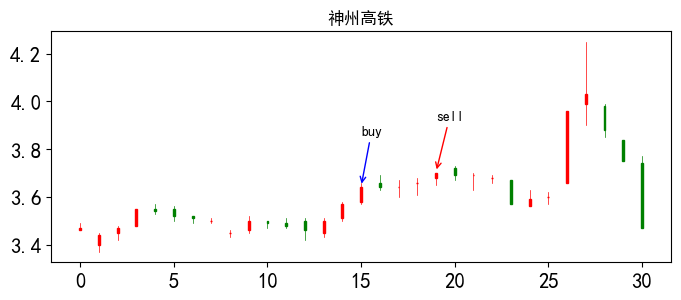

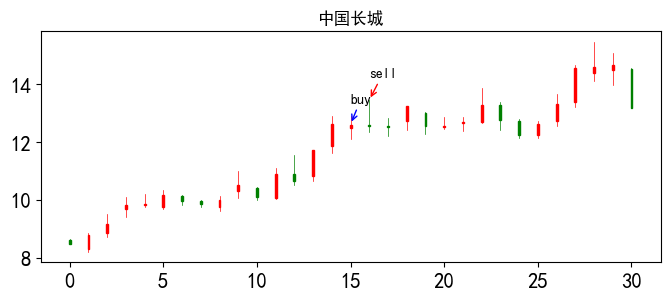

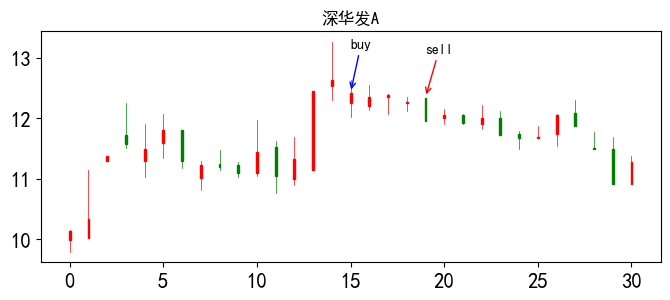

In [71]:
num = 0
for ts_code, buy_date, sell_date in zip(account.info['ts_code'], account.info['buy_date'], account.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=15, right_offset=15)
    num = num + 1
    if num > 20:
        break